In [ ]:
#https://stackoverflow.com/questions/47732102/unknown-output-of-opencvs-calcopticalflowfarneback

In [1]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import cv2
import os
import seaborn as sns
sns.set_style('white')

font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 15}

matplotlib.rc('font', **font)


import scipy as sp
from scipy import signal

In [51]:
# in windows: "G:/Other computers/My MacBook Air/thermal-project-data/cycling"
# in mac: "../../../Documents/thermal-project-data/cycling/"
fileToRead = []
for root, dirs, files in os.walk("G:/Other computers/My MacBook Air/thermal-project-data/cycling"):
    # select file name
    for file in files:
        # check the extension of files
        if file.endswith('.MP4'):
            # print whole path of files
            fileToRead.append(os.path.join(root, file))
    
for file in fileToRead:
    print(file)

In [2]:
#testFile = ['G:/Other computers/My MacBook Air/thermal-project-data/cycling/split/20221014T111320-clip3.MP4'] #prasoon
#testFile = ['C:/temp_data/20221014T111320-clip3.MP4'] #prasoon
#testFile = ['G:/Other computers/My MacBook Air/thermal-project-data/cycling/split/20221013T141554-clip2.MP4']
# 20221014T111320-clip3.MP4 - high movment:
testFile = ["../../../Documents/thermal-project-data/cycling/20221014T111320.MP4"]

In [3]:
frameWidth = 1080
frameHeight = 1440

In [4]:
# some global variables

# pixel_t is a list which store n number of lists where each list is of size image_height*image_width. n is the number of frames
# the elements inside the list are pixel intensity values at that pixel
pixel_t = []

# a tuple, which stores two list. These lists corresponds to flow vector along x and y axis.
prev_delta = ()

# this variabel keeps a track of the number of times track_pixel() has run. Each list is of size image_height*image_width
count_track_pixel = 0;

# a 2D array to store the pixel history over time (or over frames) 
# the starting pixels are ofcourse 0 to height*width of the image

#pixel_hist_y, pixel_hist_x = np.mgrid[0:frameWidth:1, 0:frameHeight:1]
#pixel_hist_y = np.array([pixel_hist_y],dtype=np.int32) #make it a 3d array
#pixel_hist_x = np.array([pixel_hist_x],dtype=np.int32)
pixel_hist_y, pixel_hist_x = np.mgrid[0:frameHeight:1, 0:frameWidth:1].reshape(2,-1).astype(int)
pixel_hist_x = np.array([pixel_hist_x])
pixel_hist_y = np.array([pixel_hist_y])

#pixel_hist_x = np.array([np.arange(0,frameWidth*frameHeight,1)])
#pixel_hist_y = np.array([np.arange(0,frameWidth*frameHeight,1)])

def track_pixel(img, flow, step=1):
    '''
    All we need is the current pixel location given the output by optical flow
    
    '''
    # we will change global variables
    global pixel_t,count_track_pixel,prev_delta,count_track_pixel,pixel_hist_x,pixel_hist_y, poi_DOF_x, poi_DOF_y, current_y, current_x;
    
    # get the height and the width of the frame
    h, w = img.shape[:2]
    y_, x_ = np.mgrid[step/2:h:step, step/2:w:step].reshape(2,-1).astype(int)
    
    # only on the first run
    if count_track_pixel == 0:
        print("First Frame Processed")
        y, x = np.mgrid[step/2:h:step, step/2:w:step].reshape(2,-1).astype(int)
    else:
        y, x = current_y, current_x
        # the line below does not make sense and needs to be removed, Currently its there so that I can compare the result
        # y, x = np.mgrid[step/2:h:step, step/2:w:step].reshape(2,-1).astype(int)
        
    fx, fy = flow[y_,x_].T
    fx = fx/(1/fps)
    fy = fy/(1/fps)
    print(fx)
    print(fy)
    print("\n\n\n\n")
    
    
    # update prev_delta for the next frame
    prev_delta = (fx, fy)
    
    # both of these variable tell me the location of pixel in the current frame.
    current_x = x-fx
    current_y = y-fy
    
    # given the the flow vector is a float, we convert it to int so that we can have a pixel index
    current_x = np.int32(current_x)
    current_y = np.int32(current_y)
   
    #status = all((current_x >= 0) & (current_x <= 549)) & all((current_y >= 0) & (current_y <= 549))
    
    # clip pixels so that out of range pixels are not considered. We dont want pixels that are negative or greater than the 
    # size of the image
    current_x_ = np.clip(current_x, 0, frameWidth-1)
    current_y_ = np.clip(current_y, 0, frameHeight-1)
    
    # These variables will keep track of the initial point of LK with respect to global flow
    poi_DOF_x = current_x_[(int(y_i)*frameWidth+int(x_i))]
    poi_DOF_y = current_y_[(int(y_i)*frameWidth+int(x_i))]
    
    
    # store the upated pixel location for each frame in the global array
    pixel_hist_x = np.append(pixel_hist_x, [current_x_], axis=0)
    pixel_hist_y = np.append(pixel_hist_y, [current_y_], axis=0)
    
    # corresponding intensity value for the previous frame
    pixel_t.append(img[current_y_,current_x_])
        
    img_bgr = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
    count_track_pixel +=1
    
    return img_bgr    

def draw_flow(img, flow, step=16):
    
    # get the height and the width of the frame
    h, w = img.shape[:2]
    y, x = np.mgrid[step/2:h:step, step/2:w:step].reshape(2,-1).astype(int)
    fx, fy = flow[y,x].T
    lines = np.vstack([x, y, x-fx, y-fy]).T.reshape(-1, 2, 2)
    # line[0] denotes information of the first pixel where -
    # - line[0][0][0] denotes the current pixel location of the 
    # - line[0][1][1] denotes the previous pixel location (curret loc-velocity vector)
    lines = np.int32(lines + 0.5)
    
    # lines[:,0,0] all x locations of current frame 
    # lines[:,0,1] all y locations of current frame
    # lines[:,1,0] all x locations of prev frame 
    # lines[:,1,1] all y locations of prev frame
    
    
    #pixel_loc_x = lines[:,1,0].clip(min=0,max=549)
    #pixel_loc_y = lines[:,1,1].clip(min=0,max=549)
    
    #pixel_t.append(img[pixel_loc_x,pixel_loc_y])
    
    #print(img[pixel_loc_x,pixel_loc_y]) 
    
    #print(lines[:,0,0]) # does not change
    #print("\n\n\n")
    
    img_bgr = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
    cv2.polylines(img_bgr, lines[50:90], 0, (0, 255, 0))

    for (x1, y1), (_x2, _y2) in lines:
        cv2.circle(img_bgr, (x1, y1), 1, (0, 255, 0), -1)

    return img_bgr

def draw_hsv(flow):
    h, w = flow.shape[:2]
    fx, fy = flow[:,:,0], flow[:,:,1]
    ang = np.arctan2(fy, fx) + np.pi
    v = np.sqrt(fx*fx+fy*fy)
    hsv = np.zeros((h, w, 3), np.uint8)
    hsv[...,0] = ang*(180/np.pi/2)
    hsv[...,1] = 255
    hsv[...,2] = np.minimum(v*4, 255)
    bgr = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)

    return bgr

In [6]:
# event to register click for the lucas kanade optical flow
def click_event(event, x, y, flags, params):
    global old_points, first_point;
    if event == cv2.EVENT_LBUTTONDOWN:
        old_points = np.array([[x,y,]], dtype=np.float32)
        first_point = old_points
        
# lucas kanade params
lk_param = dict(winSize=(350,350), maxLevel=24, criteria=(cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10,0.03))

In [7]:
#optflow_params = [0.000001, 1, 10000, 1, 1, 1.2, 0]
optflow_params = [0.5, 500, 2, 3, 5, 1.2, 0]

# variable to just test
flow_global = 0;
bigFrameCount = 0;
bigfailedFrameCount = 0

# this variable will store the intensity hostory of the tracked pixel as per LK algorithm
# the first value in this list is of the point selected by the user
intensity_xy = []
pixel_hist_x_lk = []
pixel_hist_y_lk = []


# Load the cascade
#haarcascade_frontalface_alt2.xml
#face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
#face_cascade = cv2.CascadeClassifier('haarcascade_mcs_nose.xml')
#face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_alt2.xml')

for file in testFile:
    print("\n\nProcessing = {}".format(file))
    cap = cv2.VideoCapture(file)
    # get the total frame as per opencv2
    totalFrame = cap.get(cv2.CAP_PROP_FRAME_COUNT)
    # get the frame rate
    fps = cap.get(cv2.CAP_PROP_FPS)
    print("Total number of frames = {}".format(totalFrame))
    # if multiple files are processed than this variable tells the total number of frames
    bigFrameCount+=totalFrame;
    # we need to forward atleast one frame so that we have a 'previous' frame for optical flow  
    fastForwardFrame = 0
    plotImages = False
    # keep a tab of the frame count
    frameNumber =  0 if fastForwardFrame == 0 else fastForwardFrame
    failedFrameCount = 0
    # move frame that we want to fast forward
    while fastForwardFrame:
        correct,prev_frame = cap.read()
        prev_frame_gray = cv2.cvtColor(prev_frame,cv2.COLOR_BGR2GRAY)
        fastForwardFrame-=1;
    
    # This variable tells how many frames to process? By default its all frame i.e. totalFrame = cap.get(cv2.CAP_PROP_FRAME_COUNT)
    NosFrame = totalFrame
    # NosFrame = totalFrame
    # this variable will be reduced after each frame is processed
    frameLeft = NosFrame
    if plotImages:
        fig, ax = plt.subplots(round(np.sqrt(NosFrame)),round(np.sqrt(NosFrame)), figsize=(45,45))
    j=0;i=0
 
    correct = True
    while frameLeft and correct:
        # read the first frame of the video
        correct,frame = cap.read()
        if correct:
            # convert the first frame to grayscale
            old_gray = cv2.cvtColor(frame,cv2.COLOR_BGR2GRAY)
            
            # get the size of the frame
            height, width, channel = frame.shape
            
            # create a all-zeros mask, we are doing this to get all the pixels covered by the circle
            # mask = np.zeros((height, width), np.uint8)
            
            if frameNumber%100 == 0:
                print("\nDone {} out of {}".format(frameNumber, totalFrame))
                print("Failed Frame Till Now {}".format(failedFrameCount))

            # Create a mask image for drawing purposes
            # mask = np.zeros_like(old_gray)

            #roi = old_gray[y:y+h,x:x+w]
            roi = old_gray

            # calculate dense optical flow of the ROI only if this ROI is not the first ROI that we are processing
            # We need to be on the second frame to have a flow vector from the first frame
            
            #cv2.imshow("Frame", roi)
            if frameNumber != 0:
                flow = cv2.calcOpticalFlowFarneback(roi_old,roi, None, *optflow_params)
                flow_global = flow
                # LK: get the new points for optical flow
                new_points, status, error = cv2.calcOpticalFlowPyrLK(roi_old,roi, old_points, None, **lk_param)
                # LK: update the old points to new points
                old_points = new_points
                # make arrangements to plot the points
                x,y = new_points.ravel()
                frame = track_pixel(roi, flow, 1)
                cv2.circle(frame, (int(x_i),int(y_i)),5,(0,0,255),-1)
                cv2.circle(frame, (int(x),int(y)),2,(255,0,0),-1)
                cv2.circle(frame, (int(poi_DOF_x),int(poi_DOF_y)),2,(0,255,0),-1)
                cv2.imshow('flow', frame)
                # store the intensity of the point tracked by LK
                intensity_xy.append(roi[int(x),int(y)])
                pixel_hist_x_lk.append(x)
                pixel_hist_y_lk.append(y)
            else:
                cv2.imshow('image', roi)
                cv2.setMouseCallback('image', click_event)
                cv2.waitKey(0)
                
                # LK:optical flow pixel click
                x_i, y_i = first_point.ravel()
                intensity_xy.append(roi[int(y_i),int(x_i)])
                pixel_hist_x_lk.append(x_i)
                pixel_hist_y_lk.append(y_i)
                # this is the first frame and our frame of interest to indicate the ROI.
                # LK: show the first frame, so the the user can click the pixel of interest

                # LK: wait infinitely until a key is pressed.
               
                print("Initial Pixel X = {}, Y = {}".format(x_i, y_i))
                
            roi_old = roi
            
            #key = cv2.waitKey(1) 
            key = cv2.waitKey(int((1/fps)*1000))
            if key == 27 or key == ord('q'):
                break

            if plotImages:    
                ax[j,i].imshow(roi)
                ax[j,i].set_title("Frame No. {}".format(frameNumber))
                i+=1;
                if i==round(np.sqrt(NosFrame)):
                    i=0
                    j+=1


            frameLeft-=1; frameNumber+=1
   
        else:
            cap.release()
            cv2.destroyAllWindows()
            print("Gracefully Closed, Error!")
            break;
            
    bigfailedFrameCount+=failedFrameCount
    cap.release()
    cv2.destroyAllWindows()
    print("Completed = {}".format(file))



Processing = ../../../Documents/thermal-project-data/cycling/20221014T111320.MP4
Total number of frames = 1579.0

Done 0 out of 1579.0
Failed Frame Till Now 0
Initial Pixel X = 621.0, Y = 764.0
First Frame Processed
[3.3149702e-22 1.0063175e-15 1.4584906e-13 ... 2.5057043e-08 2.8375478e-08
 2.0930134e-08]
[2.0423137e-19 3.1664756e-13 2.0632201e-11 ... 5.4776706e-08 2.7059611e-08
 1.1819615e-09]





[ 1.4301652e-41  1.0050037e-15  1.4567628e-13 ... -5.2486405e-07
  2.7577453e-08  2.4401638e-09]
[-8.4508779e-38  3.1613354e-13  2.0606026e-11 ...  1.3768214e-07
  6.5346804e-08 -4.2540216e-10]





[ 1.7205717e-39  1.2254279e-15  4.3374974e-12 ... -3.8696403e-08
 -5.6942298e-08 -7.0411632e-10]
[-9.3921425e-36  3.6021547e-13  4.2930753e-10 ... -2.3674209e-08
  6.1383942e-09 -2.7873259e-10]





[2.2976599e-20 2.0983562e-15 1.6021851e-11 ... 8.3508525e-08 9.3177249e-08
 3.9594510e-09]
[ 1.9167340e-18 -2.5452220e-14  2.7853425e-10 ...  1.9207210e-08
 -2.2617552e-08 -1.2834799e-10]





[ 9.

In [15]:
pixel_t = np.array(pixel_t)

In [115]:
# fiding the pixel of interest in a flattened array
# y*frameWidth+x
#595*frameWidth+569

In [16]:
pixel_hist_x.shape

(525, 1555200)

In [18]:
#pixel_hist_x[:,(int(y_i)*frameWidth+int(x_i))]

In [19]:
#pixel_hist_y[:,(int(y_i)*frameWidth+int(x_i))]

In [20]:
#np.array(pixel_hist_x_lk, dtype=np.int32)

In [21]:
#np.array(pixel_hist_y_lk, dtype=np.int32)

In [22]:
def compute_fft(s, sampling_rate, n = None, scale_amplitudes = True):
    '''Computes an FFT on signal s using numpy.fft.fft.
    
       Parameters:
        s (np.array): the signal
        sampling_rate (num): sampling rate
        n (integer): If n is smaller than the length of the input, the input is cropped. If n is 
            larger, the input is padded with zeros. If n is not given, the length of the input signal 
            is used (i.e., len(s))
        scale_amplitudes (boolean): If true, the spectrum amplitudes are scaled by 2/len(s)
    '''
    if n == None:
        n = len(s)
        
    fft_result = np.fft.fft(s, n)
    num_freq_bins = len(fft_result)
    fft_freqs = np.fft.fftfreq(num_freq_bins, d = 1 / sampling_rate)
    half_freq_bins = num_freq_bins // 2
 
    fft_freqs = fft_freqs[:half_freq_bins]
    fft_result = fft_result[:half_freq_bins]
    fft_amplitudes = np.abs(fft_result)
    
    if scale_amplitudes is True:
        fft_amplitudes = 2 * fft_amplitudes / (len(s))
    
    return (fft_freqs, fft_amplitudes)

In [23]:
#intensityDOF = pixel_t[:,(int(y_i)*frameWidth)]
print("Pixel of Interest Is = {}, {}".format(x_i, y_i))
intensityDOF = pixel_t[:,(int(y_i)*frameWidth+int(x_i))]

Pixel of Interest Is = 565.0, 587.0


0.569390332561174


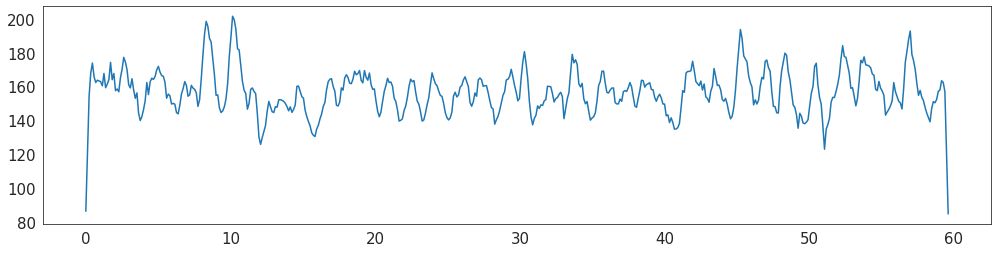

In [77]:
#spolight
# size = 5
# window = sp.signal.gaussian(M=size, std=5)
# window /= window.sum()
# filteredA = np.convolve(intensityDOF, window, mode='same')



# fig, ax = plt.subplots(1,1, figsize=(17,4))
# ax.plot([i/fps for i in range(0,len(intensityDOF))], filteredA)
# #ax.set_xlim(1,60)
# F,A = compute_fft(intensityDOF, fps)
# highestFreq = F[np.argmax(A[1:])+1]
# print(highestFreq)

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


0.05024032346128006


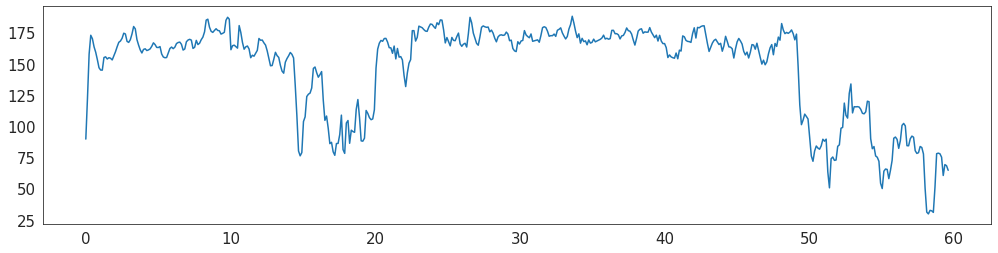

In [24]:
size = 5
window = sp.signal.gaussian(M=size, std=5)
window /= window.sum()
filteredA = np.convolve(intensityDOF, window, mode='same')



fig, ax = plt.subplots(1,1, figsize=(17,4))
ax.plot([i/fps for i in range(0,len(intensityDOF))], filteredA)
#ax.set_xlim(1,60)
F,A = compute_fft(intensityDOF, fps)
highestFreq = F[np.argmax(A[1:])+1]
print(highestFreq)

In [127]:
# lets check if the above result is random or are we doing well with the pixel selection
count = 0
concernedPixels = []
for pixelNo in range(0,pixel_t.shape[1]):
    
    size = 5
    window = sp.signal.gaussian(M=size, std=5)
    window /= window.sum()
    filteredA = np.convolve(pixel_t[:,pixelNo], window, mode='same')
    
    
    F,A = compute_fft(filteredA, fps)
    highestFreq = F[np.argmax(A[1:])+1]
    if highestFreq >= 0.5 and highestFreq <= 0.7:
        concernedPixels.append(pixelNo)
        #print("{} -- {:.2f}".format(pixelNo, highestFreq))
        count+=1
print("{} entried found".format(count))

52997 entried found


In [12]:
xx = np.isin(al,c)

In [22]:
xx.shape

(1440, 1080)

In [44]:
np.full((1440,1080),False)

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

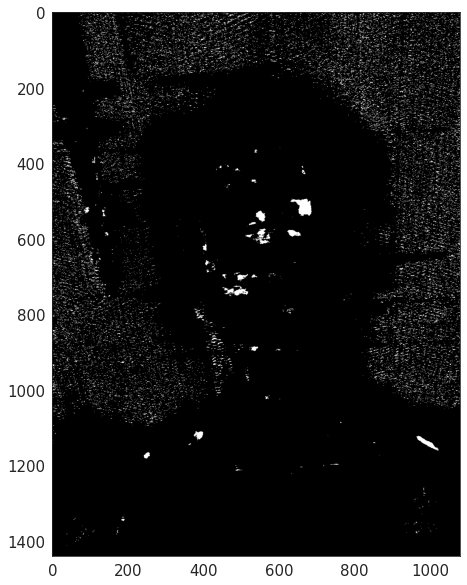

In [49]:
fig, ax = plt.subplots(1,1,figsize=(13,10))
ax.imshow(xx, cmap='gray')

In [37]:
print(xx[0,81])

True


0.3008677656424086


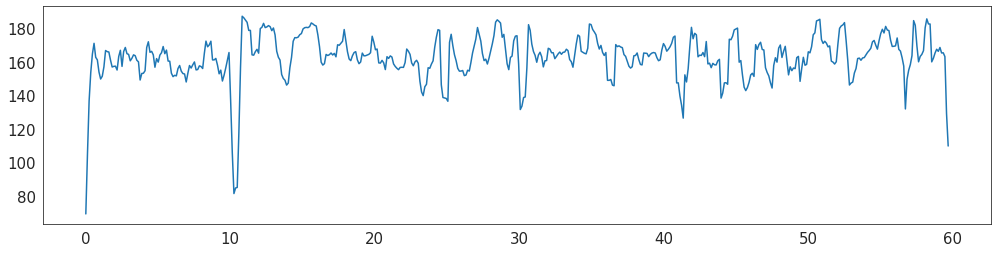

In [25]:
size = 5
window = sp.signal.gaussian(M=size, std=10)
window /= window.sum()
filteredA = np.convolve(np.array(intensity_xy), window, mode='same')

fig, ax = plt.subplots(1,1, figsize=(17,4))
ax.plot([i/fps for i in range(0,len(intensity_xy))], filteredA)
#ax.set_xlim(0,180)
F,A = compute_fft(filteredA, fps)
highestFreq = F[np.argmax(A[1:])+1]
print(highestFreq)